# House Prices: Advanced Regression Techniques

**Задача** - предсказать цену продажи для каждого дома. Для каждого id из тестового сета, нужно предсказать значение переменной SalePrice.

**Метрика** - сабмиты оцениваются по RMSE (среднеквадратическая ошибка) между логарифмом предсказанного значения и логарифмом реальной цены(использование логарифма означает что ошибки в предсказании дорогих домов и дешевых домов будут иметь влияние на результат равнозначно)

## Общая схема действий согласно кернелам с Kaggle

1. EDA - разведочный анализ данных
2. Data Cleaning
3. Data Preparation
4. Models

## 1. EDA (Разведочный анализ данных, Exploratory data analysis)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
from scipy import stats
from scipy.stats import norm
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn import model_selection, linear_model, metrics, preprocessing, pipeline

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

Считываем тренировочные и тестовые данные:

In [3]:
train_data = pd.read_csv("data/train.csv")
train_data = train_data.set_index("Id")
test_data = pd.read_csv("data/test.csv")
test_data = test_data.set_index("Id")

In [4]:
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# выводим список всех столбцов
train_data.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'Alley', u'LotShape', u'LandContour', u'Utilities', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'OverallQual', u'OverallCond',
       u'YearBuilt', u'YearRemodAdd', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF',
       u'GrLivArea', u'BsmtFullBath', u'BsmtHalfBath', u'FullBath',
       u'HalfBath', u'BedroomAbvGr', u'KitchenAbvGr', u'KitchenQual',
       u'TotRmsAbvGrd', u'Functional', u'Fireplaces', u'FireplaceQu',
       u'GarageType', u'GarageYrBlt', u'GarageFinish', u'GarageCars'

### Описание признаков

**Категориальные**

1. MSSubClass: Тип недвижимости
2. MSZoning: Классификатор зоны
3. Street: Тип покрытия подъездной дороги
4. Alley: Тип пешеходного доступа
5. LotShape: Общая форма дома      
6. LandContour: "ровность" (пологость) недвижимости
7. Utilities: Коммуникации
8. LotConfig: Конфигурация лота
9. LandSlope: Склон недвижимости
10. Neighborhood: Локация в пределах города
11. Condition1: Близость к объектам
12. Condition2: Близость к объектам (если больше чем один доступен)
13. BldgType: Тип здания
14. HouseStyle: Стиль недвижимости
15. OverallQual: Общая оценка материалов и отделки дома
16. OverallCond: Общая оценка состояния дома
17. RoofStyle: Тип крыши
18. RoofMatl: Материал крыши
19. Exterior1st: Наружная отделка
20. Exterior2nd: Наружная отделка (если больше чем один тип доступен)
21. MasVnrType: Тип облицовки кирпичем
22. ExterQual: Оценка качества материалов наружной отделки
23. ExterCond: Оценка состояния материалов наружной отделки
24. Foundation: Тип фундамента
25. BsmtQual: Категория высоты подвала
26. BsmtCond: Общая оценка состояния подвала
27. BsmtExposure: Вид из подвала
28. BsmtFinType1: Уровень отделки подвала
29. BsmtFinType2: Уровень отделки подвала (если несколько уровней)
30. Heating: Тип отопления
31. HeatingQC: Качество и состояние отопления
32. CentralAir: Центральный кондиционер
33. Electrical: Система электроснабжения
34. KitchenQual: Качество кухни
35. Functional: Функциональность
36. FireplaceQu: Качественно камина
37. GarageType: Расположение гаража
38. GarageFinish: Внутренняя отделка гаража
39. GarageQual: Качество гаража
40. GarageCond: Состояние гаража
41. PavedDrive: Асфальтированная дорога
42. PoolQC: Качество бассейна
43. Fence: Качество ограждения
44. MiscFeature: Характеристики не относящиеся к другим категориям
45. SaleType: Тип продажи
46. SaleCondition: Состояние сделки

**Количественные**

1. LotFrontage: Linear feet of street connected to property
2. LotArea: Lot size in square feet
3. YearBuilt: Original construction date
4. YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
5. MasVnrArea: Masonry veneer area in square feet
6. BsmtFinSF1: Площадь подвала с отделкой типа 1
7. BsmtFinSF2: Площадь подвала с отделкой типа 2
8. BsmtUnfSF: Площадь подвала без отделки
9. TotalBsmtSF: Общая площадь подвала
10. 1stFlrSF: First Floor square feet
11. 2ndFlrSF: Second floor square feet
12. LowQualFinSF: Low quality finished square feet (all floors)
13. GrLivArea: Above grade (ground) living area square feet
14. BsmtFullBath: Basement full bathrooms
15. BsmtHalfBath: Basement half bathrooms
16. FullBath: Full bathrooms above grade
17. HalfBath: Half baths above grade
18. Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
19. Kitchen: Kitchens above grade
20. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
21. Fireplaces: Number of fireplaces
22. GarageYrBlt: Year garage was built
23. GarageCars: Вместимость гаража в машинах
24. GarageArea: Площадь гаража
25. WoodDeckSF: Wood deck area in square feet
26. OpenPorchSF: Open porch area in square feet
27. EnclosedPorch: Enclosed porch area in square feet
28. 3SsnPorch: Three season porch area in square feet
29. ScreenPorch: Screen porch area in square feet
30. PoolArea: Pool area in square feet
31. MiscVal: $Value of miscellaneous feature
32. MoSold: Month Sold (MM)
33. YrSold: Year Sold (YYYY)

### Анализируем целевую переменную

In [7]:
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Минимальная цена дома больше нуля и выглядит адекватной

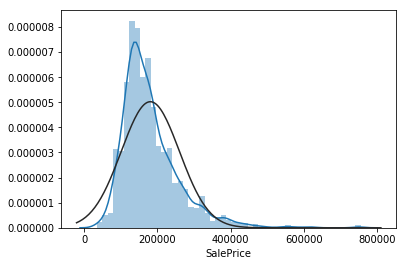

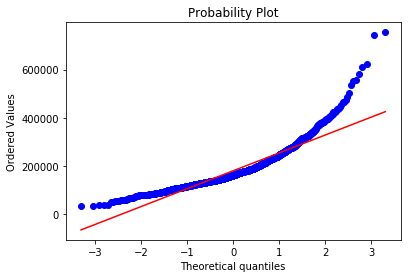

In [8]:
seaborn.distplot(train_data['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

Величина не распределена нормально. Имеется перекос вправо.

In [9]:
#skewness and kurtosis
print("Перекос: %f" % train_data['SalePrice'].skew())
print("Куртозис: %f" % train_data['SalePrice'].kurt())

Перекос: 1.882876
Куртозис: 6.536282


Куртозис (kurtosis) - Коэффициент эксцесса (коэффициент островершинности) в теории вероятностей — мера остроты пика распределения случайной величины. - является показателем, отражающим остроту вершины и толщину хво- стов одномерного распределения.

Проблему скошенности вправо решается простой трансформацией. В случае позитивного перекоса, обычно log-трансформация хорошо работает

**Связь с цифровыми признаками**

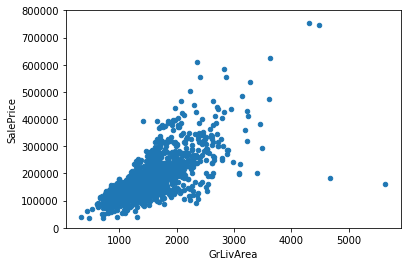

In [10]:
var = 'GrLivArea'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Имеет место линиейная зависимость между жилой площадью и стоимостью дома

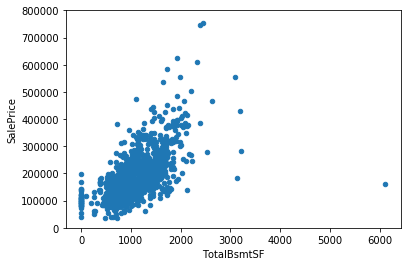

In [11]:
var = 'TotalBsmtSF'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Здесь также имеет место линейная зависимость но с большим разбросом

Из обоих графиков видно что есть выбросы - необходимо их удалить. На первом - два объекта с площадью больше 4500, на втором - TotalBsmtSF больше 5000

In [12]:
#Deleting outliers
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)
train_data = train_data.drop(train_data[(train_data['TotalBsmtSF']>4000) & (train_data['SalePrice']<300000)].index)

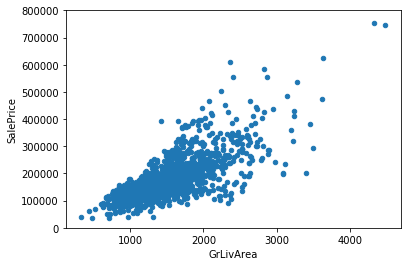

In [13]:
var = 'GrLivArea'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

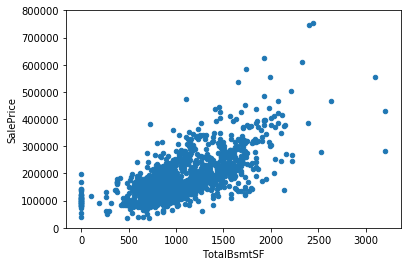

In [14]:
var = 'TotalBsmtSF'
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

**Связь с категориальными признаками**

(-0.5, 9.5, 0, 800000)

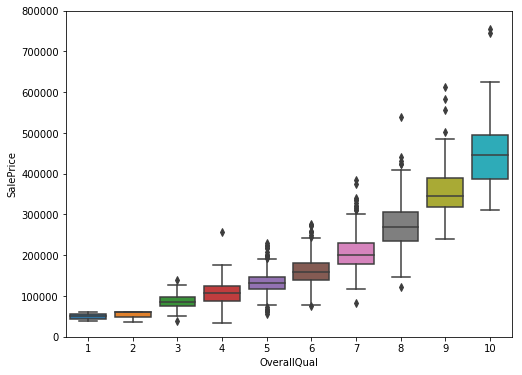

In [15]:
#box plot overallqual/saleprice
var = 'OverallQual' # Видимо общее состояние
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = seaborn.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 111.5, 0, 800000)

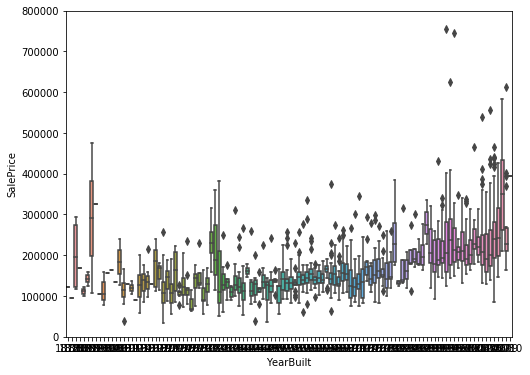

In [16]:
#box plot overallqual/saleprice
var = 'YearBuilt' # Видимо общее состояние
data = pd.concat([train_data['SalePrice'], train_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = seaborn.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

### Анализ признаков

**Строим матрицу корреляции признаков между собой**

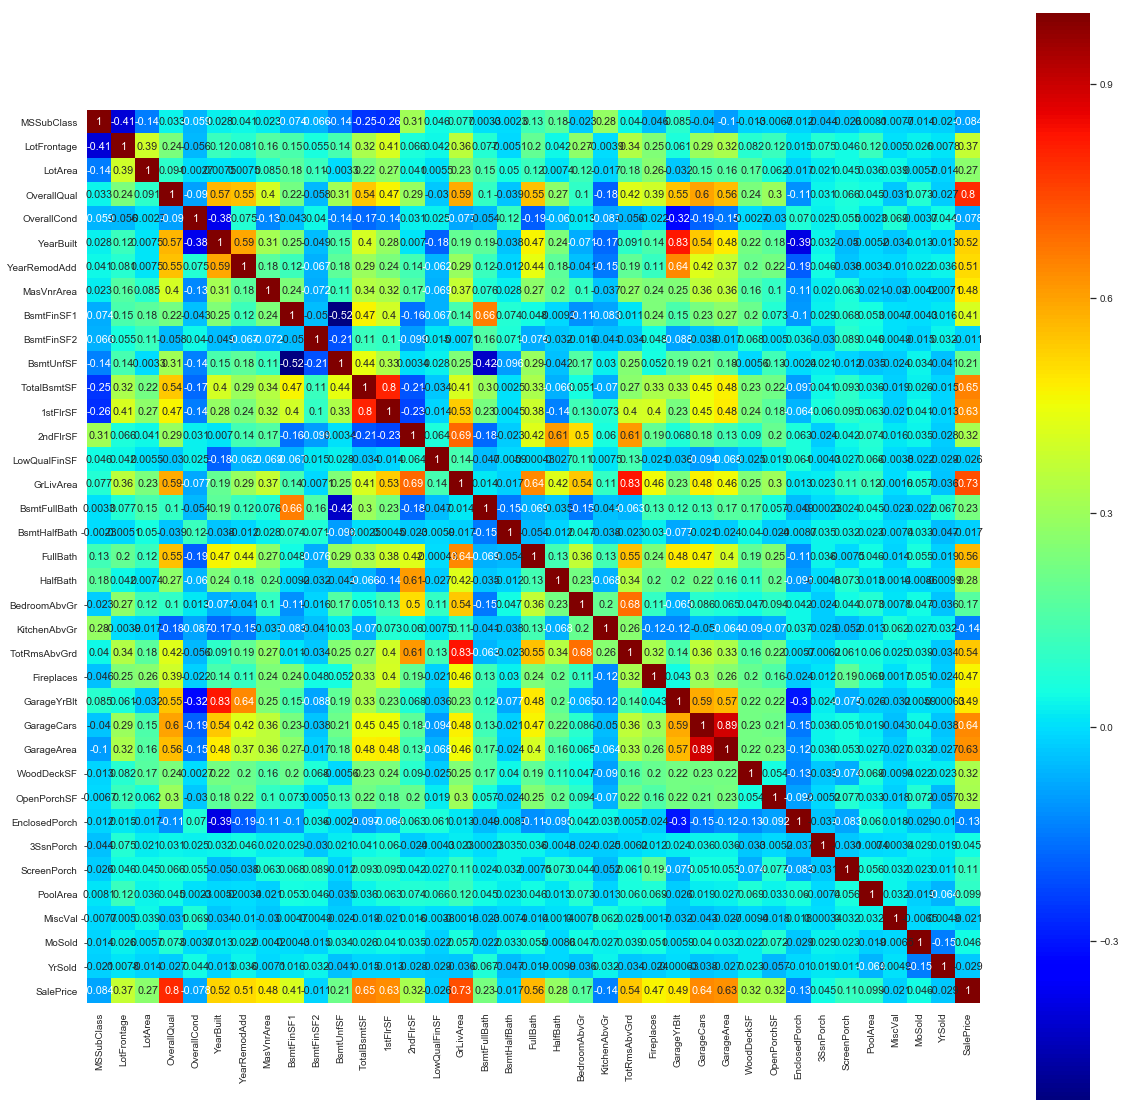

In [17]:
corrmat = train_data.corr()
seaborn.set(font_scale=0.9)
fig, axes = plt.subplots(figsize=(20,20))
seaborn.heatmap(corrmat, square=True, annot=True, cmap='jet')

**Строим матрицу корреляции SalePrice**

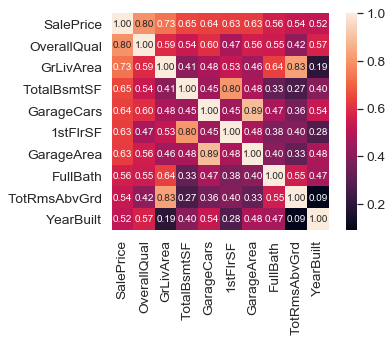

In [18]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_data[cols].values.T)
seaborn.set(font_scale=1.25)
hm = seaborn.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Здесь можно увидеть признаки наиболее коррелирующие с SalePrice**

GarageCars и GarageArea очень сильно коррелируют - можно оставить только GarageCars т.к. его корреляция с SalePrice выше

у TotalBsmtSF и 1stFloor такая же ситуация

TotRmsAbvGrd and GrLivArea аналогично

## 2. Data Cleaning

Общая последовательность очистки данных:

* удаляем лишние столбцы
* заполняем пропуски

### Преобразуем целевую переменную

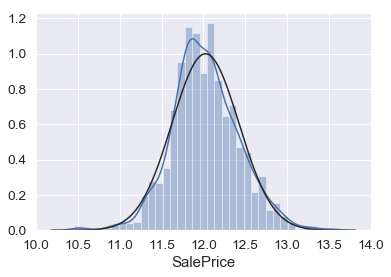

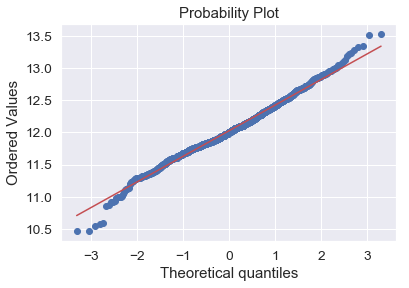

In [19]:
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])
seaborn.distplot(train_data['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

### Удаляем лишние столбцы

In [20]:
columns_to_remove = ['GarageArea', 'TotalBsmtSF', 'TotRmsAbvGrd']
train_data = train_data.drop(columns_to_remove, axis=1)
test_data = test_data.drop(columns_to_remove, axis=1)

### Заполняем пропуски

In [21]:
# Смотрим какие типы столбцов присутствуют в данных
train_data.get_dtype_counts()

float64     4
int64      30
object     43
dtype: int64

In [22]:
# Проверяем есть ли пропуски в данных
train_data.isnull().values.any()

True

In [23]:
total = train_data.isnull().sum().sort_values(ascending=False)
percent = (train_data.isnull().sum()/train_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageCond,81,0.055556
GarageType,81,0.055556
GarageYrBlt,81,0.055556
GarageFinish,81,0.055556


Для категориальных признаков просто заполним пропуски строками "Nan", которые в дальнейшем станут еще одной категорией.

А вот над количественными признаками надо подумать какими значениями заполнять пропуски: нулями, средними значениями или есть еще какие-нибудь варианты.

**Определим значения, которыми мы будем заполнять пропуски в количественных признаках**

Есть нексколько вариантов - площади/протяженности, количество, год

1. LotFrontage: Linear feet of street connected to property - **mean**
2. LotArea: Lot size in square feet - **mean**
3. YearBuilt: Original construction date - **mean**
4. YearRemodAdd: Remodel date (same as construction date if no remodeling or additions) - **null**
5. MasVnrArea: Masonry veneer area in square feet - если не указана, то возможно ноль? - **null**
6. BsmtFinSF1: Площадь подвала с отделкой типа 1 - если не указана, то возможно ноль? - **null**
7. BsmtFinSF2: Площадь подвала с отделкой типа 2 - если не указана, то возможно ноль? - **null**
8. BsmtUnfSF: Площадь подвала без отделки - если не указана, то возможно ноль? - **null**
9. TotalBsmtSF: Общая площадь подвала - **mean**
10. 1stFlrSF: First Floor square feet - **mean**
11. 2ndFlrSF: Second floor square feet - **null**
12. LowQualFinSF: Low quality finished square feet (all floors) - если не указана, то возможно ноль? - **null**
13. GrLivArea: Above grade (ground) living area square feet - **mean**
14. BsmtFullBath: Basement full bathrooms - если не указано, то возможно ноль? - **null**
15. BsmtHalfBath: Basement half bathrooms - если не указано, то возможно ноль? - **null**
16. FullBath: Full bathrooms above grade - если не указано, то возможно ноль? - **null**
17. HalfBath: Half baths above grade - если не указано, то возможно ноль? - **null**
18. Bedroom: Bedrooms above grade (does NOT include basement bedrooms) - если не указано, то возможно ноль? - **null**
19. Kitchen: Kitchens above grade - если не указано, то возможно ноль? - **null**
20. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms) - **mean**
21. Fireplaces: Number of fireplaces - если не указано, то возможно ноль? - **null**
22. GarageYrBlt: Year garage was built - **null**
23. GarageCars: Вместимость гаража в машинах - если не указано, то возможно ноль? - **null**
24. GarageArea: Площадь гаража - если не указано, то возможно ноль? - **null**
25. WoodDeckSF: Wood deck area in square feet - если не указано, то возможно ноль? - **null**
26. OpenPorchSF: Open porch area in square feet - если не указано, то возможно ноль? - **null**
27. EnclosedPorch: Enclosed porch area in square feet - если не указано, то возможно ноль? - **null**
28. 3SsnPorch: Three season porch area in square feet - если не указано, то возможно ноль? - **null**
29. ScreenPorch: Screen porch area in square feet - если не указано, то возможно ноль? - **null**
30. PoolArea: Pool area in square feet - если не указано, то возможно ноль? - **null**
31. MiscVal: $Value of miscellaneous feature - если не указано, то возможно ноль? - **null**
32. MoSold: Month Sold (MM) - **mean**
33. YrSold: Year Sold (YYYY) - **mean**

Создадим два списка признаков, соответствующие их группам: числовые и категориальные (эти списки даны на странице соревнования). Уберем признак Id, так как он не несет смысловой нагрузки.

In [24]:
numerical_features = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt','LotArea', 'YearBuilt', 
                     'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                     'BsmtHalfBath', 'FullBath', 'HalfBath', 'Fireplaces',
                     'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                      '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
                     'BedroomAbvGr', 'KitchenAbvGr']
cat_features = train_data.columns.drop(numerical_features).drop(["SalePrice"]).tolist()

# removed ['GarageArea', 'TotalBsmtSF', 'TotRmsAbvGrd']

In [25]:
print(len(numerical_features), len(cat_features))

(30, 46)


Сосздадим два списка количественных признаков - заполняемых средними значениями и нулями

In [26]:
numerical_features_mean = ['LotFrontage', 'LotArea', 'YearBuilt', '1stFlrSF', 
                           'GrLivArea', 'MoSold', 'YrSold']
numerical_features_null = train_data.columns.drop(cat_features).drop(numerical_features_mean).drop(["SalePrice"]).tolist()

In [27]:
print(len(numerical_features_mean), len(numerical_features_null))

(7, 23)


Заполняем пропуски в категориальных признаках

In [28]:
train_data[cat_features] = train_data[cat_features].fillna("NAN")
test_data[cat_features] = test_data[cat_features].fillna("NAN")
train_data[cat_features].isnull().values.any()

False

Заполняем пропуски в количественных признаках

In [29]:
for col in (numerical_features_null):
    train_data[col] = train_data[col].fillna(0)
    test_data[col] = test_data[col].fillna(0)

## 3. Data Preparation

Общая последовательность обработки данных:
* разделяем выборку на трейн и тест
* собираем пайплайн
* подбор параметров по сетке
* оценка по отложенному тесту

### Разделяем выборку на трейн и тест

In [30]:
X = train_data.drop(['SalePrice'], axis=1)
y = train_data['SalePrice']
X.shape

(1458, 76)

**Разделяем на выборку и тест**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                     test_size=0.3, 
                                     random_state=0)

Посмотреть распределения целевой метки:

Text(0.5,1,'test_data')

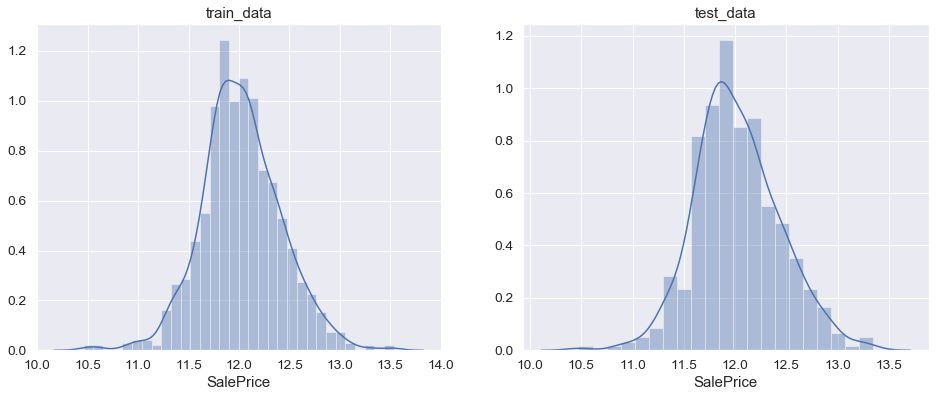

In [32]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
seaborn.distplot(y_train)
plt.title('train_data')

plt.subplot(1,2,2)
seaborn.distplot(y_test)
plt.title('test_data')

### Transformer Objects

In [33]:
from sklearn.base import TransformerMixin, BaseEstimator, clone

class SelectColumnsTransfomer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that provides column selection
    
    Allows to select columns by name from pandas dataframes in scikit-learn
    pipelines.
    
    Parameters
    ----------
    columns : list of str, names of the dataframe columns to select
        Default: [] 
    
    """
    def __init__(self, columns=[]):
        self.columns = columns

    def transform(self, X, **transform_params):
        """ Selects columns of a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
            
        Returns
        ----------
        
        trans : pandas DataFrame
            contains selected columns of X      
        """
        trans = X[self.columns].copy() 
        return trans
    
    def fit(self, X, y=None, **fit_params):
        """ Do nothing function
        
        Parameters
        ----------
        X : pandas DataFrame
        y : default None
                
        
        Returns
        ----------
        self  
        """
        return self

In [34]:
class DataFrameFunctionTransformer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer providing imputation or function application
    
    Parameters
    ----------
    impute : Boolean, default False
        
    func : function that acts on an array of the form [n_elements, 1]
        if impute is True, functions must return a float number, otherwise 
        an array of the form [n_elements, 1]
    
    """
    
    def __init__(self, func, impute = False):
        self.func = func
        self.impute = impute
        self.series = pd.Series() 

    def transform(self, X, **transformparams):
        """ Transforms a DataFrame
        
        Parameters
        ----------
        X : DataFrame
            
        Returns
        ----------
        trans : pandas DataFrame
            Transformation of X 
        """
        
        if self.impute:
            trans = pd.DataFrame(X).fillna(self.series).copy()
        else:
            trans = pd.DataFrame(X).apply(self.func).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Fixes the values to impute or does nothing
        
        Parameters
        ----------
        X : pandas DataFrame
        y : not used, API requirement
                
        Returns
        ----------
        self  
        """
        
        if self.impute:
            self.series = pd.DataFrame(X).apply(self.func).copy()
        return self

In [35]:
class DataFrameFeatureUnion(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that unites several DataFrame transformers
    
    Fit several DataFrame transformers and provides a concatenated
    Data Frame
    
    Parameters
    ----------
    list_of_transformers : list of DataFrameTransformers
        
    """ 
    def __init__(self, list_of_transformers):
        self.list_of_transformers = list_of_transformers
        
    def transform(self, X, **transformparamn):
        """ Applies the fitted transformers on a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
        
        Returns
        ----------
        concatted :  pandas DataFrame
        
        """
        
        concatted = pd.concat([transformer.transform(X)
                            for transformer in
                            self.fitted_transformers_], axis=1).copy()
        return concatted
    
    def fit(self, X, y=None, **fitparams):
        """ Fits several DataFrame Transformers
        
        Parameters
        ----------
        X : pandas DataFrame
        y : not used, API requirement
        
        Returns
        ----------
        self : object
        """
        
        self.fitted_transformers_ = []
        for transformer in self.list_of_transformers:
            fitted_trans = clone(transformer).fit(X, y=None, **fitparams)
            self.fitted_transformers_.append(fitted_trans)
        return self

In [36]:
class ToDummiesTransformer(BaseEstimator, TransformerMixin):
    """ A Dataframe transformer that provide dummy variable encoding
    """
    
    def transform(self, X, **transformparams):
        """ Returns a dummy variable encoded version of a DataFrame
        
        Parameters
        ----------
        X : pandas DataFrame
        
        Returns
        ----------
        trans : pandas DataFrame
        
        """
    
        trans = pd.get_dummies(X).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Do nothing operation
        
        Returns
        ----------
        self : object
        """
        return self

In [37]:
class DropAllZeroTrainColumnsTransformer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that provides dropping all-zero columns
    """

    def transform(self, X, **transformparams):
        """ Drops certain all-zero columns of X
        
        Parameters
        ----------
        X : DataFrame
        
        Returns
        ----------
        trans : DataFrame
        """
        
        trans = X.drop(self.cols_, axis=1).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Determines the all-zero columns of X
        
        Parameters
        ----------
        X : DataFrame
        y : not used
        
        Returns
        ----------
        self : object
        """
        
        self.cols_ = X.columns[(X==0).all()]
        return self

### Cобираем пайплайн

In [38]:
from sklearn.pipeline import Pipeline, make_pipeline

**Столбцы площади**

Мы начнем со столбцов описывающих всевозможные площади. Столбцы со скошенным распределением должны быть прологорифмированны. Просмотрев данные, можно заметить что столбцы со скошенными распределениями это столбцы площади.

Для определения столбцов с площадью используем регулярное выражение, затем преобразуем значения к флоат, заполним пустые значения средними значенимяи и применим log(x+1) трансформацию.

In [39]:
area_cols = X_train.columns[X_train.columns.str.contains('(?i)area|(?i)porch|(?i)sf')].tolist()

area_cols_pipeline = make_pipeline(  
        SelectColumnsTransfomer(area_cols),
        DataFrameFunctionTransformer(func = lambda x: x.astype(np.float64)),
        DataFrameFunctionTransformer(func = np.mean, impute=True),
        DataFrameFunctionTransformer(func = np.log1p) 
    )

**Столбцы объектов**

The object columns are the categorical columns. Reading the data set description, we see that NaN values are allowed for each column. Consequently, we assume that possible levels of the categorical values are known beforehand and that the NaNs are correctly encoded. So though we access the values of the test data, we don't use information not known before the analyzing the data

So what we will do here is to determine all possible levels across all categories, construct dummy variables for all variables and levels (this is not efficient!) and then drop the combinations that do not occur. Particularly, when fitting the pipeline to the training data sets and applying to the test sets, we will only keep levels contained in the training data sets!

We simply filter the columns by data type, construct the object levels, impute, convert to dummy notation and drop all zero columns

In [40]:
object_columns = X_train.columns[X_train.dtypes == object].tolist()
object_levels = np.union1d(X_train[object_columns].fillna('NAN'), X_test[object_columns].fillna('NAN'))

categorical_cols_pipeline = make_pipeline(
        SelectColumnsTransfomer(object_columns),
        DataFrameFunctionTransformer(lambda x:'NAN', impute=True),
        DataFrameFunctionTransformer(lambda x:x.astype('category', categories=object_levels)),
        ToDummiesTransformer(),
        DropAllZeroTrainColumnsTransformer()
    )

**Оставшиеся столбцы**

The remaining columns are mostly integer columns. However, if an integers column in a training set has a missing value in the test set the data type will be float in the test set. So, without actually using information beforehand, we just convert the remaining columns to float, store the mean and impute if necessary on train and test sets.

Typically, integer columns provide some form of count data, hence we do not use a log transform here. Note however, that the GarageBltYear is also a remaining column. For simplicity, we treat it like the other count-like columns

In [41]:
remaining_cols = [x for x in X_train.columns.tolist() if x not in object_columns and x not in area_cols]

remaining_cols_pipeline = make_pipeline(
        SelectColumnsTransfomer(remaining_cols),
        DataFrameFunctionTransformer(func = lambda x: x.astype(np.float64)),
        DataFrameFunctionTransformer(func = np.mean, impute=True)
    )

**Используем пайплайн**

We put the pipelines together using the DataFrameFeatureUnion transformer. To demonstrate that we get a DataFrame we simply use fit_transform on the training set and show the first rows

In [42]:
preprocessing_features = DataFrameFeatureUnion([area_cols_pipeline, categorical_cols_pipeline, 
                                                remaining_cols_pipeline])
preprocessing_features.fit_transform(X_train).head()

,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,WoodDeckSF,...,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
465,9.039671,4.919981,6.424869,0.0,6.052089,6.947937,0.000000,0.0,6.947937,0.000000,...,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,8.0,2009.0
1219,8.738896,0.000000,0.000000,0.0,0.000000,6.511745,5.484797,0.0,6.816736,0.000000,...,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,7.0,2006.0
329,9.383369,0.000000,0.000000,0.0,6.739337,7.276556,6.536692,0.0,7.666222,0.000000,...,2.0,0.0,5.0,1.0,0.0,1930.0,2.0,0.0,7.0,2009.0
603,9.214532,0.000000,6.672033,0.0,4.787492,6.833032,6.896694,0.0,7.557995,4.795791,...,2.0,1.0,3.0,1.0,1.0,1992.0,2.0,0.0,2.0,2006.0
1407,9.041448,0.000000,6.487684,0.0,4.727388,6.645091,0.000000,0.0,6.645091,4.077537,...,1.0,0.0,2.0,1.0,0.0,1988.0,2.0,0.0,3.0,2009.0


## 4. Models

Общая последовательность обработки данных:
    
* подбор параметров по сетке
* оценка по отложенному тесту

### Gridsearch and Crossvalidation

We use nested cross validation to estimate the generalization performance. See the 3rd example here

Unfortunately, nested cross validation is not able to return the best model parameters for each fold (and probably never will be). However, for simplicity, we just assume that the model parameters are stable across the cross validation folds on the training sets.

**Import librairies**

In [43]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb
import lightgbm as lgb

**Define a cross validation strategy**

In [44]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Base Models

**Ridge regression**

In [45]:
pipe_ridge = make_pipeline(preprocessing_features, RobustScaler(), Ridge())

In [46]:
param_grid_ridge = {'ridge__alpha' : [6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]}
pipe_ridge_gs = GridSearchCV(pipe_ridge, param_grid=param_grid_ridge, scoring = 'neg_mean_squared_error', cv=3) 
pipe_ridge_gs.fit(X_train, y_train)
print(pipe_ridge_gs.best_params_)
result = rmse_cv(pipe_ridge_gs)
print('Ridge score: ', np.mean(result))

{'ridge__alpha': 10}
('Ridge score: ', 0.11465074056654904)


last result: 0.11591828513961518

**Lasso regression**

In [47]:
pipe_lasso = make_pipeline(preprocessing_features, RobustScaler(), Lasso())

In [48]:
param_grid_lasso = {'lasso__alpha' : [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]}
pipe_lasso_gs = GridSearchCV(pipe_lasso, param_grid=param_grid_lasso, scoring = 'neg_mean_squared_error', cv=3)
pipe_lasso_gs.fit(X_train, y_train)
print(pipe_lasso_gs.best_params_)
result = rmse_cv(pipe_lasso_gs)
print('Lasso score', np.mean(result))

{'lasso__alpha': 0.0006}
('Lasso score', 0.11467700234295511)


last result: 0.11544389794542451

**Random forest**

In [49]:
rfr = RandomForestRegressor(max_depth=50, n_estimators=100)
pipe_rfr = make_pipeline(preprocessing_features, RobustScaler(), rfr)
result = rmse_cv(pipe_rfr)
print('Random forest result ', np.mean(result))

('Random forest result ', 0.14672754947778921)


last result: 0.14833919865260156

**Elastic Net Regression**

In [50]:
ENet = make_pipeline(preprocessing_features, RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
result = rmse_cv(ENet)
print('ElasticNet result ', np.mean(result))

('ElasticNet result ', 0.11394557130467904)


**Gradient Boosting regressor**

In [51]:
GBoostRegr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GBoost = make_pipeline(preprocessing_features, RobustScaler(), GBoostRegr)
result = rmse_cv(GBoost)
print('Gradient Boosting result ', np.mean(result))

('Gradient Boosting result ', 0.12169417277731669)


**XGBoost regressor**

In [52]:
model_xgb_regr = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_xgb = make_pipeline(preprocessing_features, RobustScaler(), model_xgb_regr)
result = rmse_cv(model_xgb)
print('XGBoost regressor result ', np.mean(result))

('XGBoost regressor result ', 0.12300739190144665)


**LightGBM regressor**

In [53]:
model_lgb_regr = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb = make_pipeline(preprocessing_features, RobustScaler(), model_lgb_regr)
result = rmse_cv(model_lgb)
print('LightGBM regressor result ', np.mean(result))

('LightGBM regressor result ', 0.11911042157516494)


### Stacking models

**Averaged base models class**

Источник: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [54]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

In [55]:
averaged_models = AveragingModels(models = (pipe_ridge_gs, pipe_lasso_gs, ENet, GBoost, model_xgb, model_lgb))
score = rmse_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1113 (0.0143)



Last result: 0.1127

**Stacking averaged Models Class**

In [56]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking averaged Models Class score**

### Оценка по отложенному тесту

In [57]:
averaged_models.fit(X_train, y_train)
predicted = averaged_models.predict(X_test)

In [58]:
metrics.mean_absolute_error(y_test, predicted)

0.076574091191162763

last_result: 0.08022608785341756

In [59]:
print(y_test[:10])

Id
412     11.884496
212     12.133507
343     11.379406
304     11.917730
160     12.676079
1049    11.652696
981     12.091789
234     11.761355
255     11.884496
1363    11.560772
Name: SalePrice, dtype: float64


In [60]:
print(pipe_ridge_gs.predict(X_test)[:10])

[ 11.75723318  12.02955814  11.38155815  11.73117621  12.61023781
  11.81887869  12.27399156  11.72862654  11.83174773  11.72667761]


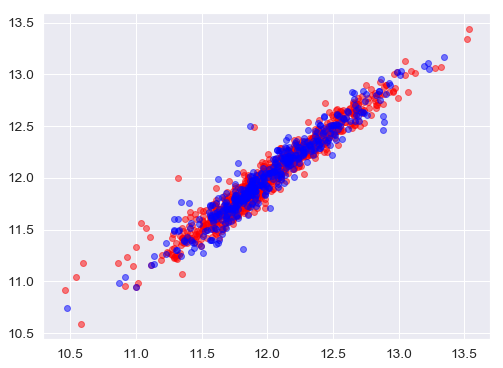

In [61]:
plt.figure(figsize=(8, 6))
plt.grid(True)
plt.scatter(y_train, pipe_ridge_gs.predict(X_train), alpha=0.5, color = 'red')
plt.scatter(y_test, pipe_ridge_gs.predict(X_test), alpha=0.5, color = 'blue')

## Test data calculations

In [62]:
predicted = np.expm1(averaged_models.predict(test_data))
test_data["SalePrice"] = predicted
test_data["SalePrice"].to_csv('stacked_models.csv', header=True)

In [63]:
test_data["SalePrice"].head()

Id
1461    118620.421947
1462    157420.742784
1463    189029.524523
1464    195169.807913
1465    193744.572568
Name: SalePrice, dtype: float64

### План действий
* проверить основные модели для регрессии, которые мы проходили на курсере:
  * линейная регрессия
  * ридж и лассо
  * случайный лес
  * градиентный бустинг
  
* попробовать добавить новые фичи

## Разобрать следующие кернелы:

In [64]:
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
# https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5

# https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding

# избавиться от выбросов
# https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

# https://www.kaggle.com/ctrlaltz/final-model

# https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1

# https://www.kaggle.com/kb2900/house-prices-from-data-cleaning-to-modeling

# pipelines:
# +++ https://www.kaggle.com/jankoch/scikit-learn-pipelines-and-pandas
# https://www.kaggle.com/kabure/houseprices-pipeline-featuretools-tpot